In [202]:
from utils import start_notebook
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier,XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [87]:
full_data = pd.read_parquet("datasets/tratados/base_completa.parquet")

In [83]:
full_data.columns

Index(['CO_MUNICIPIO', 'PERC_TP_DEPENDENCIA', 'PERC_TP_LOCALIZACAO',
       'PERC_IN_AGUA_POTAVEL', 'PERC_IN_ENERGIA_INEXISTENTE',
       'PERC_IN_ESGOTO_REDE_PUBLICA', 'PERC_IN_BIBLIOTECA_SALA_LEITURA',
       'PERC_IN_QUADRA_ESPORTES', 'PERC_IN_SALA_ESTUDIO_DANCA',
       'PERC_IN_BANDA_LARGA', 'PERC_TP_ATIVIDADE_COMPLEMENTAR',
       'SUM_QT_SALAS_UTILIZADAS', 'SUM_QT_DESKTOP_ALUNO',
       'SUM_QT_COMP_PORTATIL_ALUNO', 'MD_NOTA_TOTAL'],
      dtype='object')

In [88]:
full_data = full_data.drop(["CO_MUNICIPIO", "SUM_QT_COMP_PORTATIL_ALUNO"], axis =1)

<AxesSubplot: >

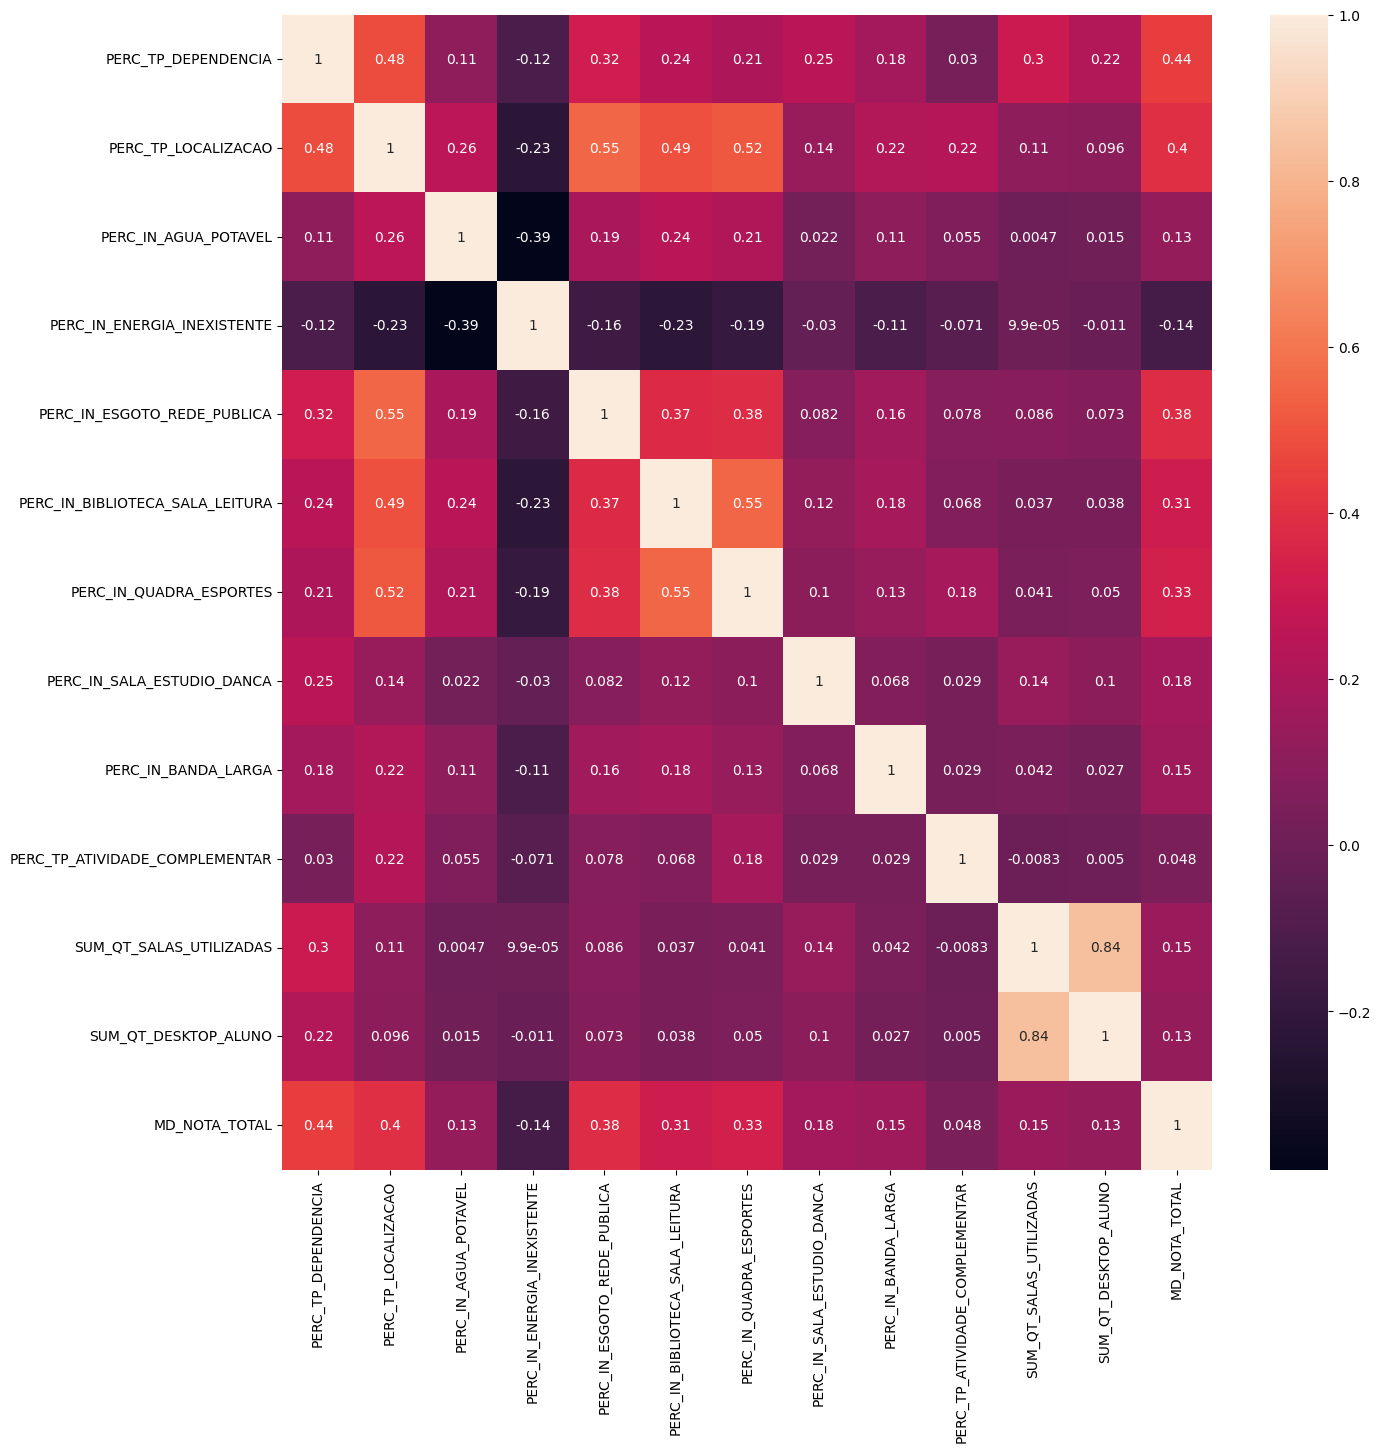

In [89]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(full_data.corr(), annot=True, ax=ax)

In [90]:
# pegando 90% dos dados para treinar e 10% para validar no final.
train_data = full_data.sample(frac=0.9, random_state=42)
valid_data = full_data.loc[~full_data.index.isin(train_data.index)]


In [91]:
print(f"len full data {len(full_data)}")
print(f"len train data {len(train_data)} ")
print(f"len train data {len(valid_data)} ")

len full data 5477
len train data 4929 
len train data 548 


In [97]:
y = train_data["MD_NOTA_TOTAL"]
train_data = train_data.drop(["MD_NOTA_TOTAL"], axis = 1)


In [99]:
x = train_data.copy()

In [100]:
kf = KFold(n_splits= 5, shuffle=True, random_state=42, )
cnt = 1
for train_index, test_index in kf.split(x,y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 3943, Test set:986
Fold:2, Train set: 3943, Test set:986
Fold:3, Train set: 3943, Test set:986
Fold:4, Train set: 3943, Test set:986
Fold:5, Train set: 3944, Test set:985


In [101]:
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [195]:
score = cross_val_score(linear_model.LinearRegression(), x, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-813.90784311 -941.89553501 -937.22055406 -785.5038713  -905.00869348]
rmse= 29.61


In [196]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), x, y, cv= kf, scoring="neg_mean_squared_error", )
print(f'Scores for each fold are: {score}')
rmse(score.mean())


Scores for each fold are: [-737.45352354 -834.14907361 -807.86458683 -699.21243585 -845.78593806]
rmse= 28.02


In [197]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

In [200]:
xgbr = xgb.XGBRegressor(seed = 20)

In [203]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

In [204]:
clf.fit(x,y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          predictor=None, random_state=None, ...),
                   n_iter=25,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [206]:
clf.score()

-697.7673643828633

In [171]:
xg_estimator = XGBRegressor(
    booster='gbtree',
    objective="reg:squarederror",
    subsample=0.7,
    colsample_bytree=0.8,
    seed=42)

In [207]:
score = cross_val_score(clf, x, y, cv= kf)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [210]:
score.mean()

-769.6045178437935

In [ ]:
# 5570
# 10 % validacao
# 20 % -> test
# 70 % train

In [ ]:
# testar com xgboost

In [174]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

In [175]:
xg_estimator.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [157]:
score = xg_estimator.score(xtrain,ytrain)

In [176]:
kfold = KFold(n_splits=10, shuffle=True)

In [177]:
kf_cv_scores = cross_val_score(xg_estimator, xtrain, ytrain, cv=kfold )

In [211]:
kf_cv_scores.mean()

0.21807529937906786

In [213]:
kf_cv_scores

array([0.2618239 , 0.25774746, 0.25645789, 0.23855913, 0.25280898,
       0.13603279, 0.2127565 , 0.15066267, 0.22707524, 0.18682844])

In [212]:
kf_cv_scores

array([0.2618239 , 0.25774746, 0.25645789, 0.23855913, 0.25280898,
       0.13603279, 0.2127565 , 0.15066267, 0.22707524, 0.18682844])

In [179]:
kf_cv_scores

array([0.2618239 , 0.25774746, 0.25645789, 0.23855913, 0.25280898,
       0.13603279, 0.2127565 , 0.15066267, 0.22707524, 0.18682844])

In [214]:
y_pred = xg_estimator.predict(xtest)

In [215]:
mse = mean_squared_error(ytest, y_pred)

In [216]:

mse**(1/2)

31.916301993091423

In [188]:
x_ax = range(len(ytest))

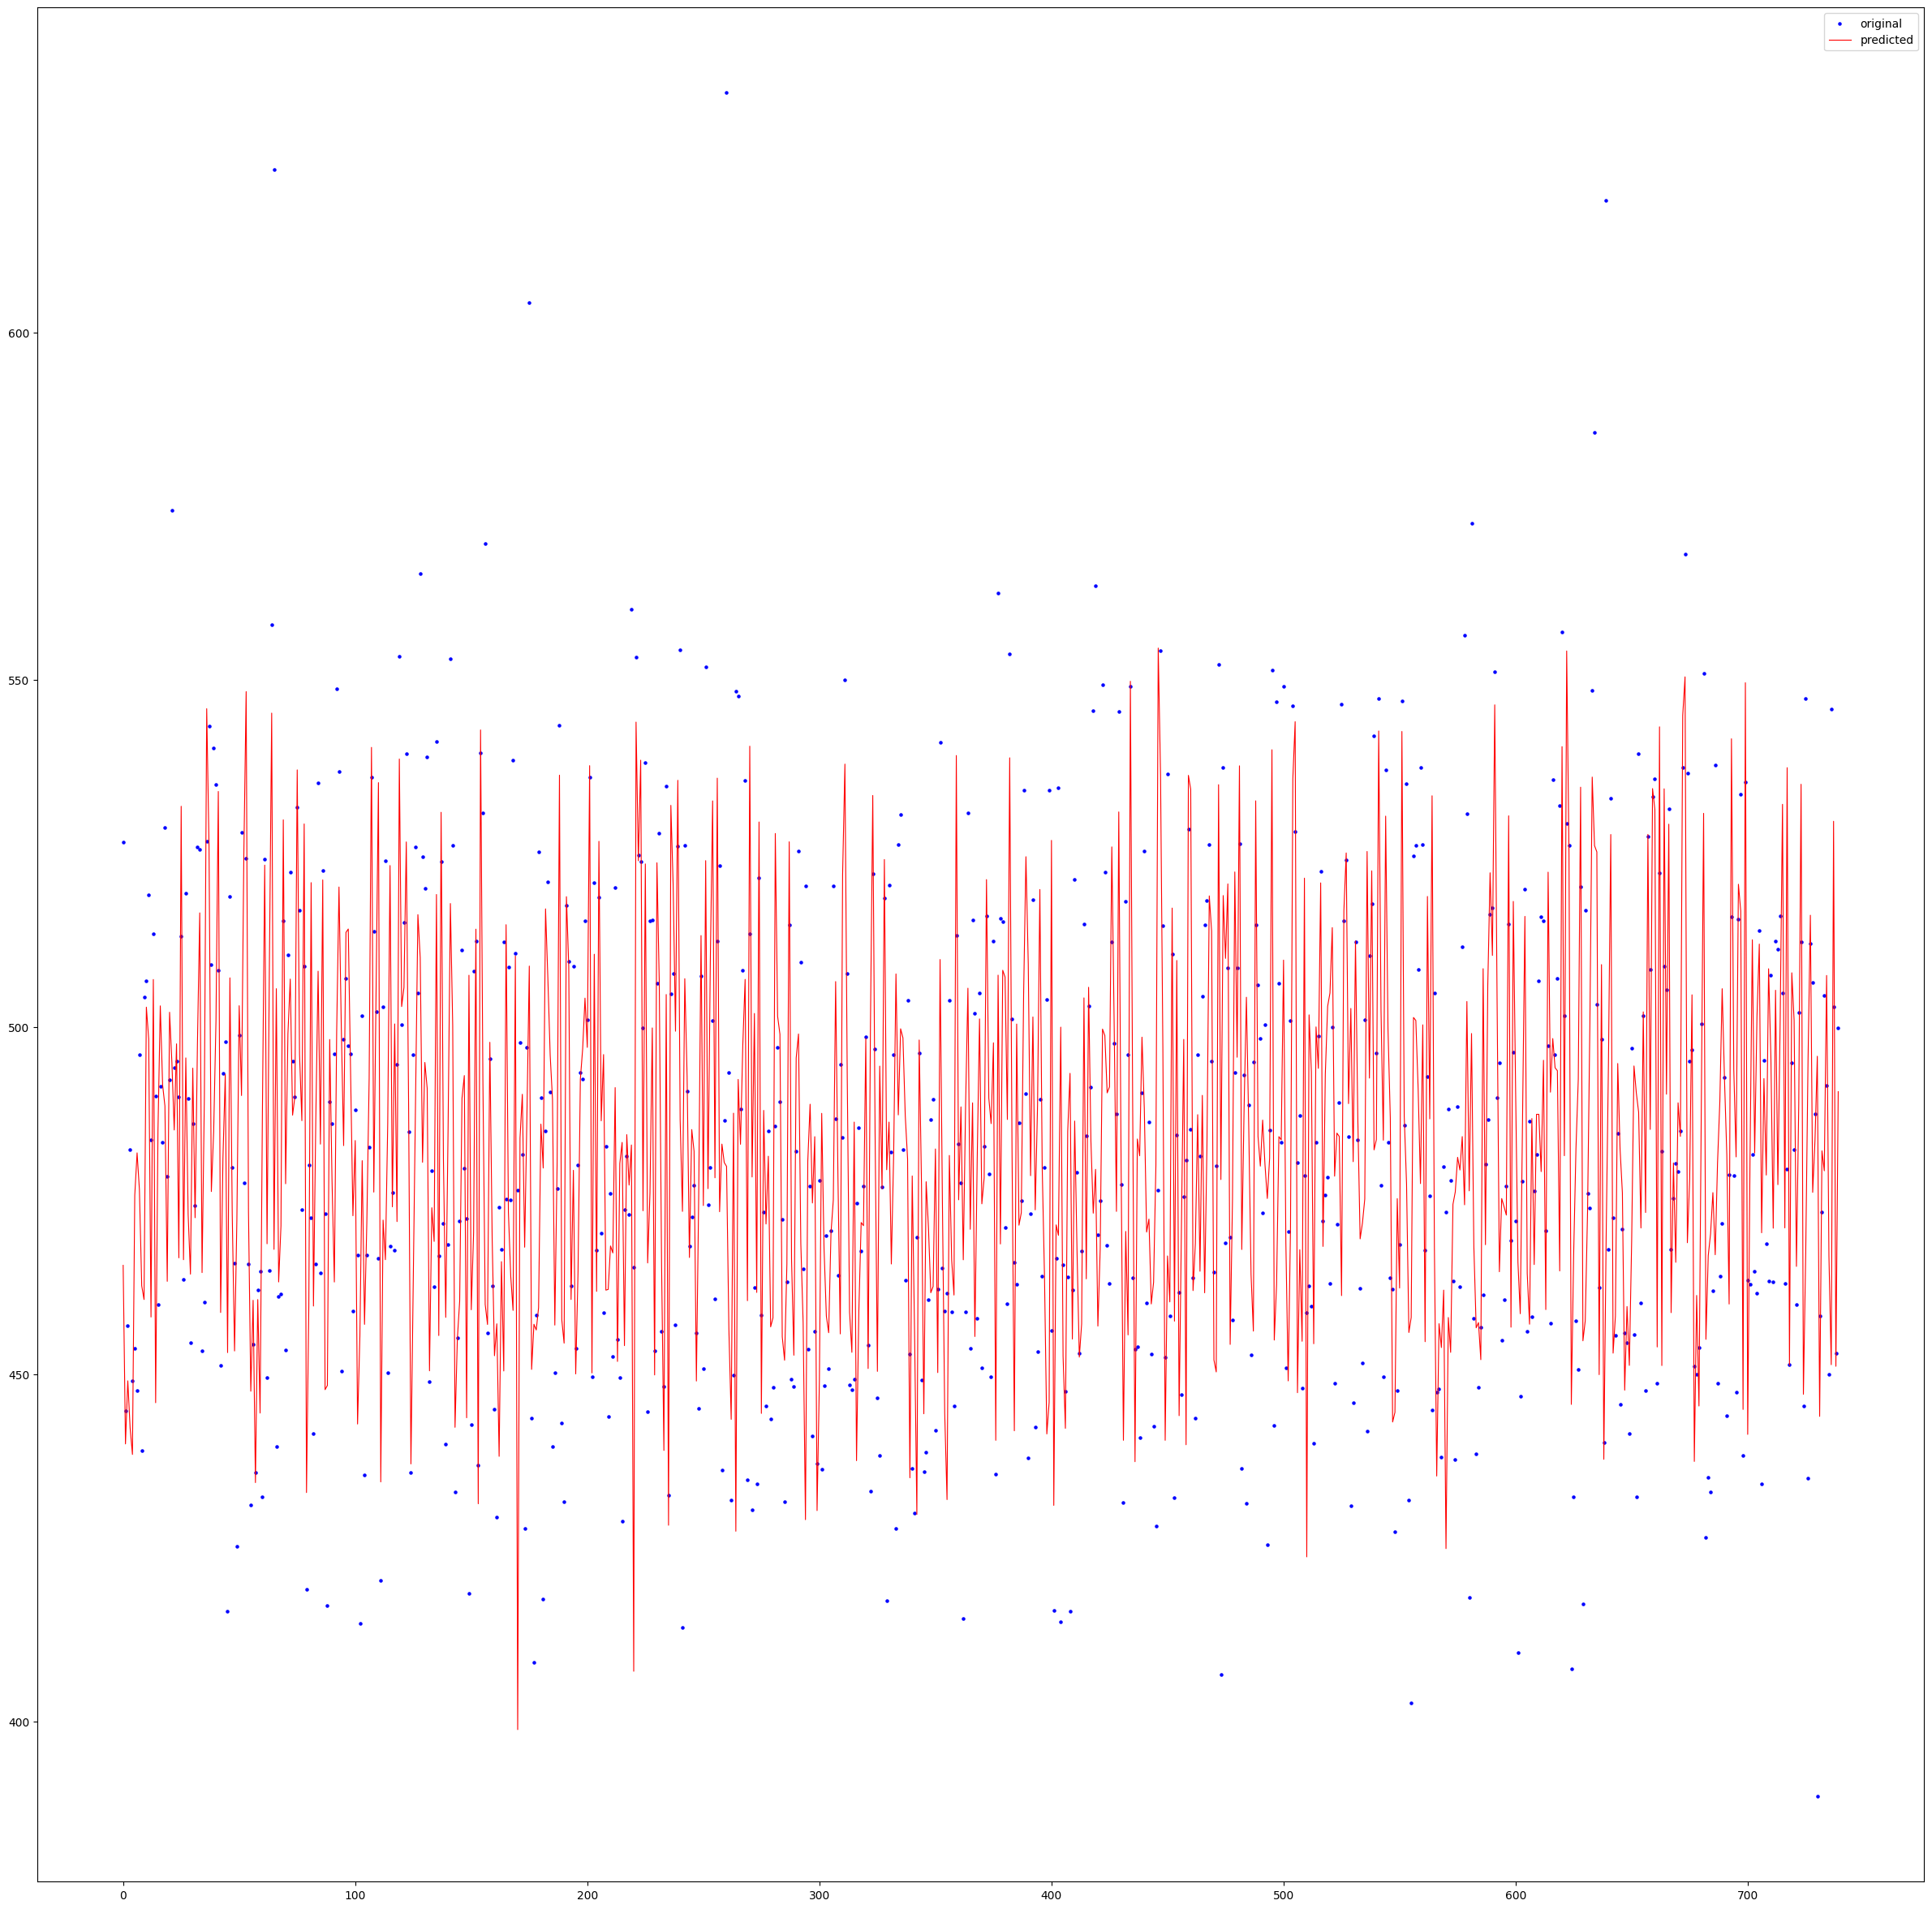

In [194]:
plt.figure(figsize=(30,30))
plt.scatter(x_ax, ytest, s = 5, color='blue', label='original' )
plt.plot(x_ax, y_pred, lw=0.8, color='red', label='predicted')
plt.legend()
plt.show()
